In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn import preprocessing
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm_
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [26]:
train = pd.read_csv('train_V2.csv')
display(train.head())
display(train.describe())

FileNotFoundError: File b'train_V2.csv' does not exist

In [27]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [28]:
train = reduce_mem_usage(train)
train.info()

NameError: name 'train' is not defined

NameError: name 'train' is not defined

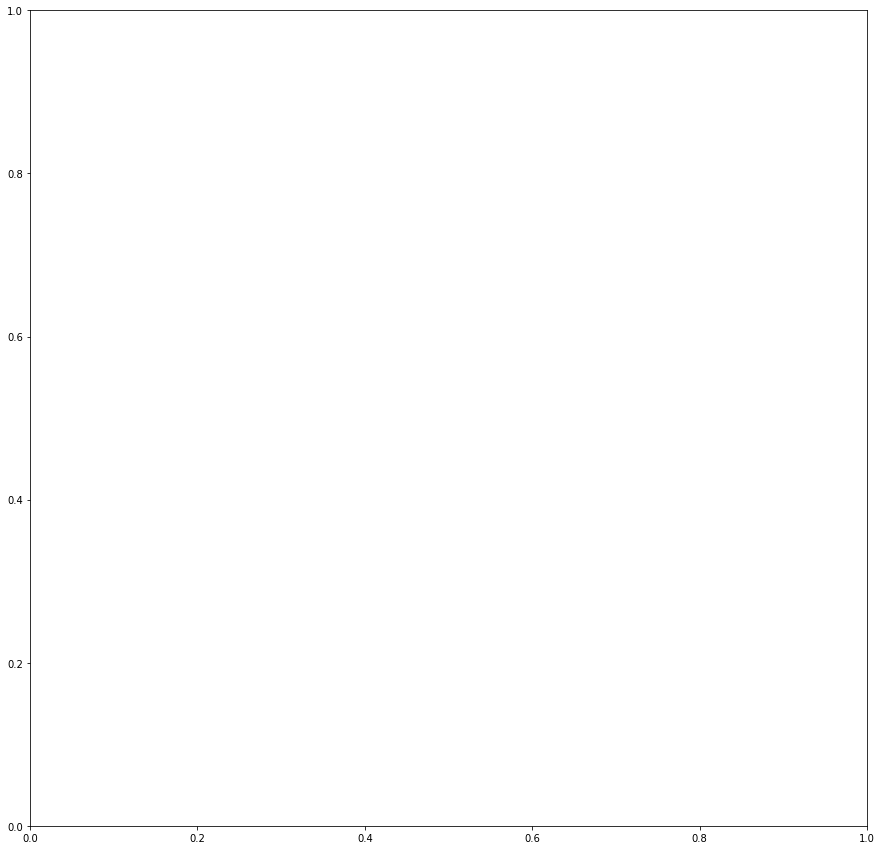

In [29]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

NameError: name 'train' is not defined

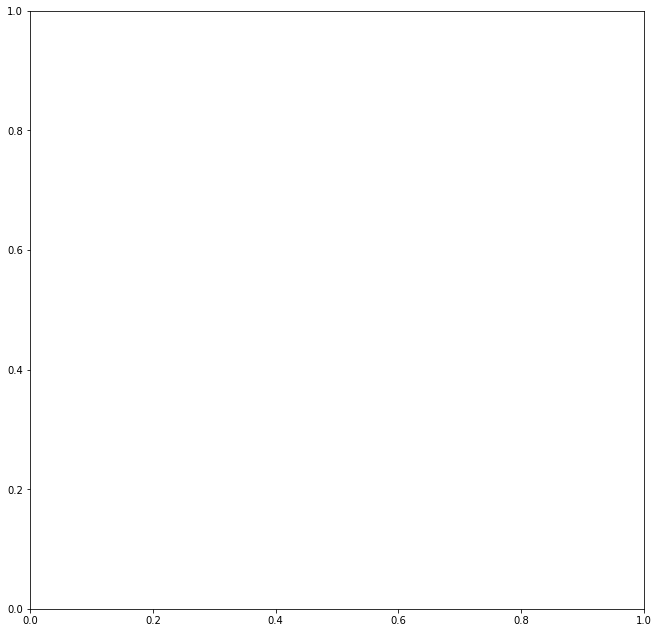

In [30]:
k = 6 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = train[cols].corr().values
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

NameError: name 'train' is not defined

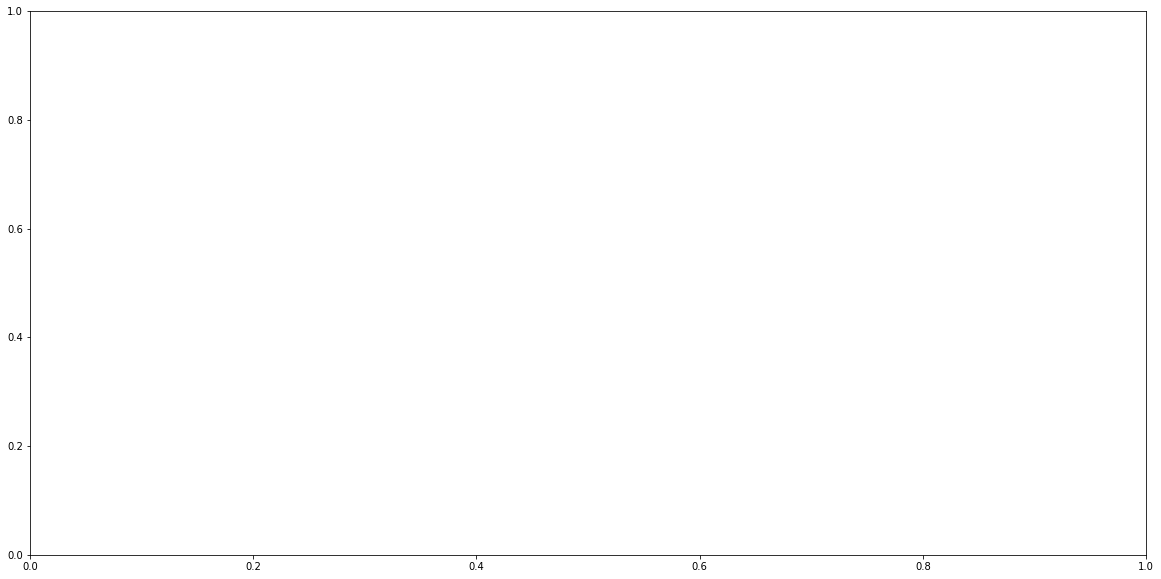

In [31]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=train[train['matchType'].str.contains('solo')],color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=train[train['matchType'].str.contains('duo')],color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=train[train['matchType'].str.contains('squad')],color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

In [32]:
def plot_one(data, column):
    data = data[data[column] < data[column].quantile(0.95)]
    plt.figure(figsize=(15,10))
    plt.title("{0} Distribution".format(column),fontsize=15)
    sns.distplot(data[column])
    plt.show()
    
    sns.jointplot(x="winPlacePerc", y=column, data=data, color="y")
    plt.show()
    

In [9]:
def show_countplot(column):
    plt.figure(figsize=(12,4))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(12, 4))
    sns.distplot(train[column], bins=50)
    plt.show()

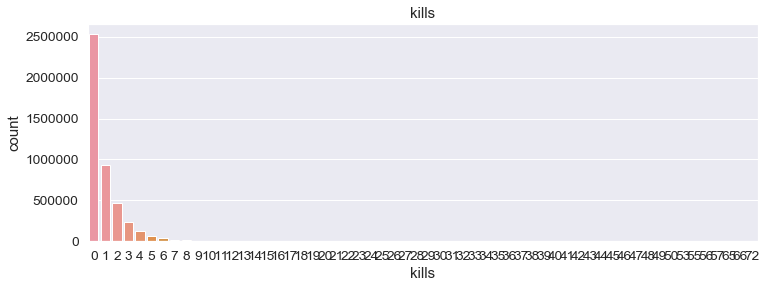

In [10]:
show_countplot('kills')

In [11]:
data = train[train['matchType'].str.contains('solo')]


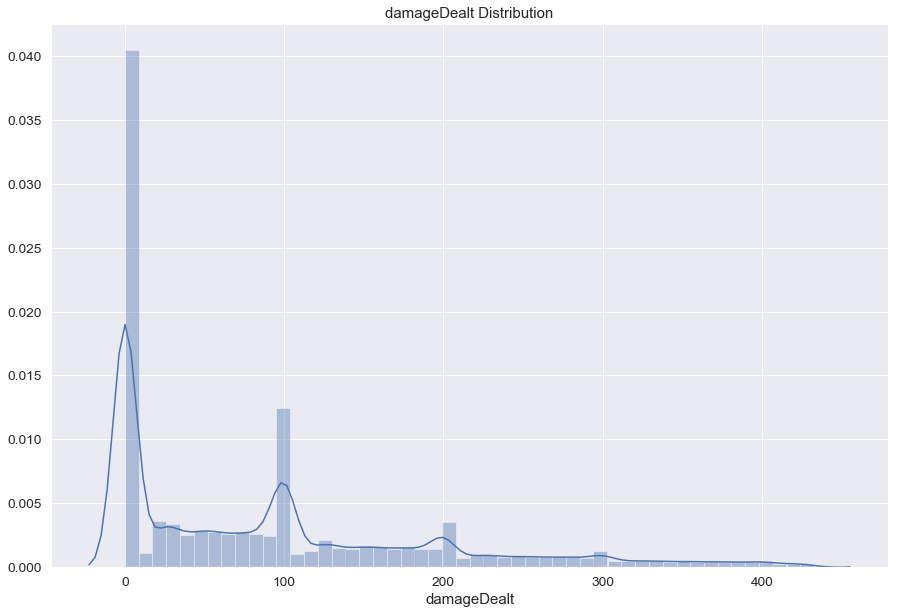

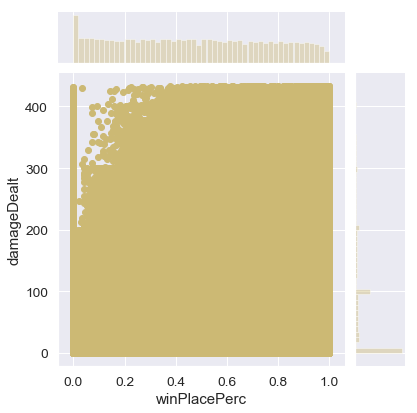

In [12]:
plot_one(data, 'damageDealt')

In [13]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = data[data['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

8627 players (0.1940%) have won without a single kill!
316 players (0.0071%) have won without dealing damage!


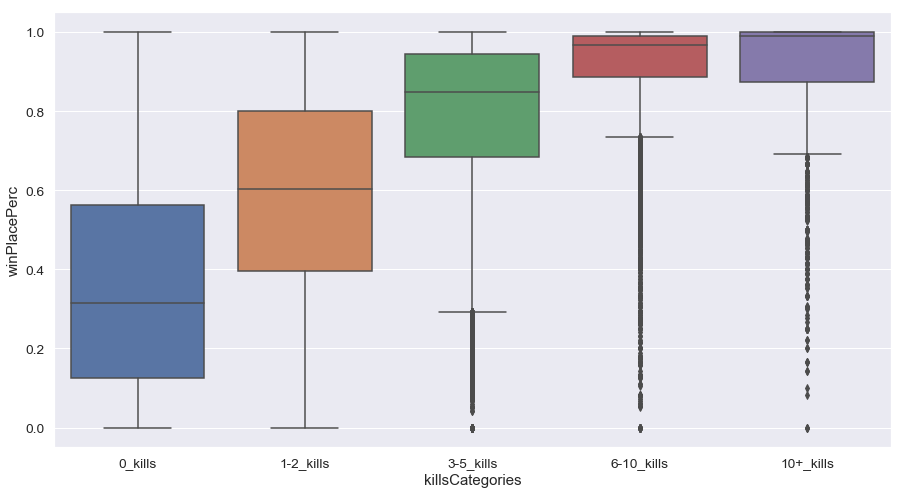

In [14]:
data['killsCategories'] = pd.cut(data['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=data)
plt.show()

In [15]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(data['walkDistance'].mean(),
                                                                                                                                          data['walkDistance'].quantile(0.99), 
                                                                                                                                        data['walkDistance'].max()))

The average person walks for nanm, 99% of people have walked 4156.0m or less, while the marathoner champion walked for 25776.0m.


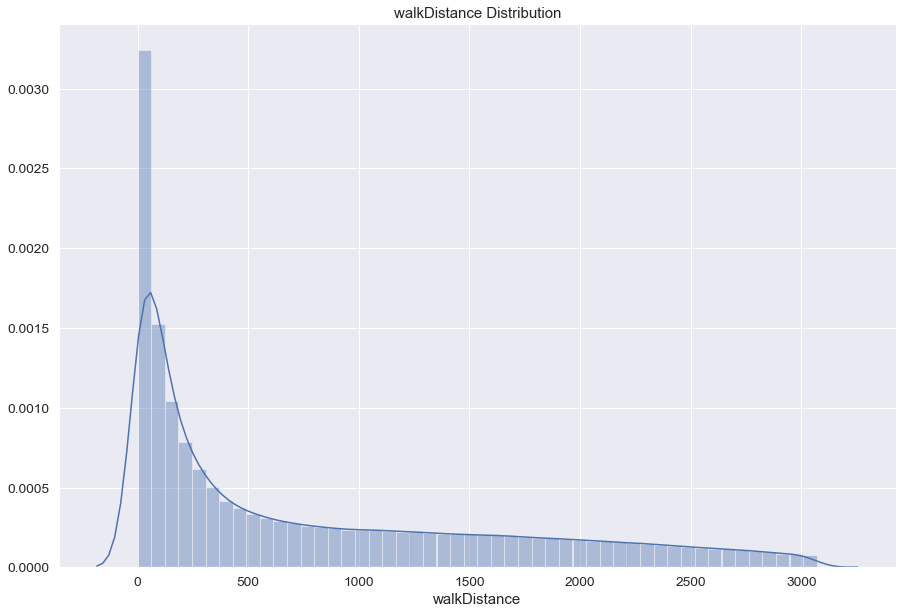

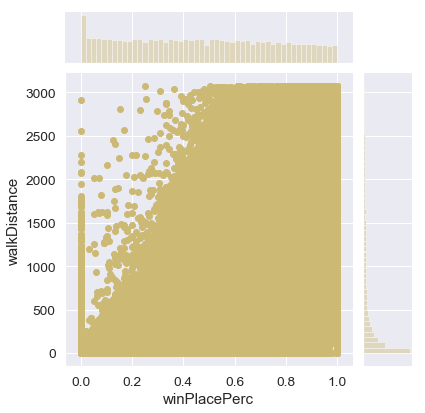

In [16]:
plot_one(data,'walkDistance')

In [17]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).".format(len(data[data['walkDistance'] == 0]), 
                                                                                                                                         100*len(data[data['walkDistance']==0])/len(data)))

30444 players (4.2242%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).


In [18]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the formula 1 champion drived for {}m.".format(data['rideDistance'].mean(), data['rideDistance'].quantile(0.99), data['rideDistance'].max()))

The average person drives for nanm, 99% of people have drived 6608.0m or less, while the formula 1 champion drived for 40704.0m.


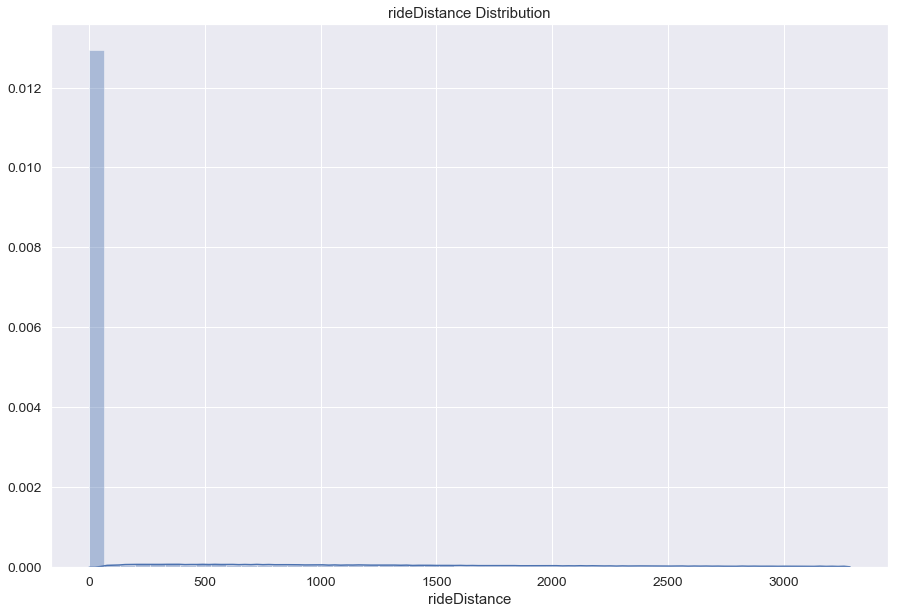

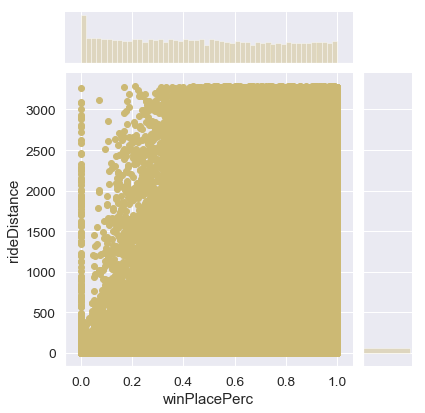

In [19]:
plot_one(data, 'rideDistance')

In [20]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet.".format(len(data[data['rideDistance'] == 0]), 100*len(data[data['rideDistance']==0])/len(train)))

576502 players (12.9639%) drived for 0 meters. This means that they don't have a driving licence yet.


In [21]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(data['swimDistance'].mean(), data['swimDistance'].quantile(0.99), data['swimDistance'].max()))

The average person swims for nanm, 99% of people have swimemd 141.48500000000058m or less, while the olympic champion swimmed for 1974.0m.


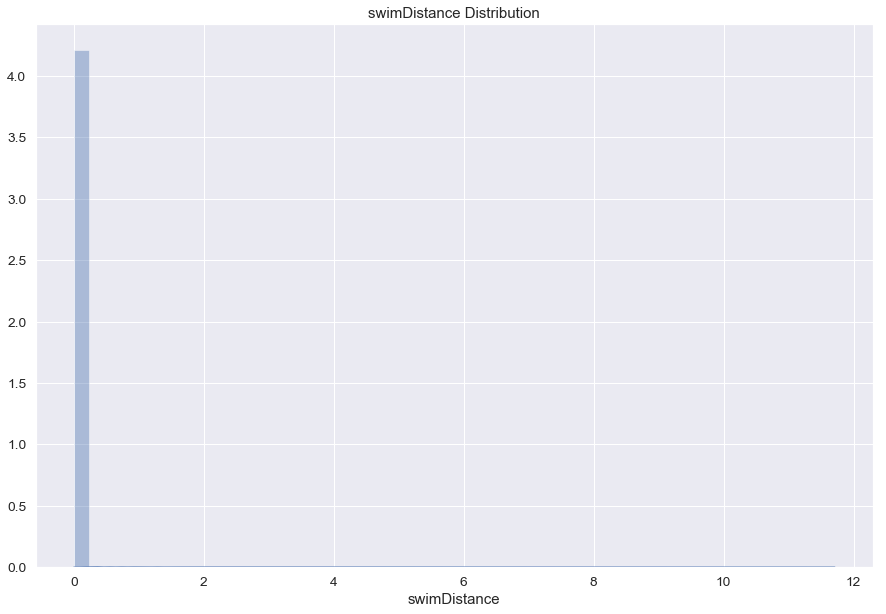

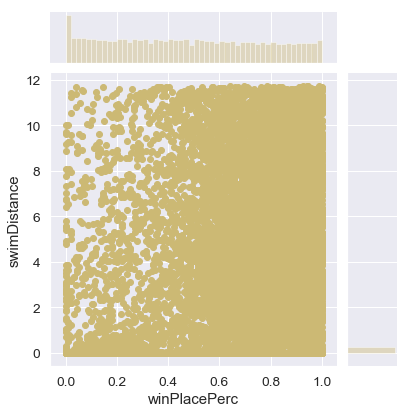

In [22]:
plot_one(data,'swimDistance')

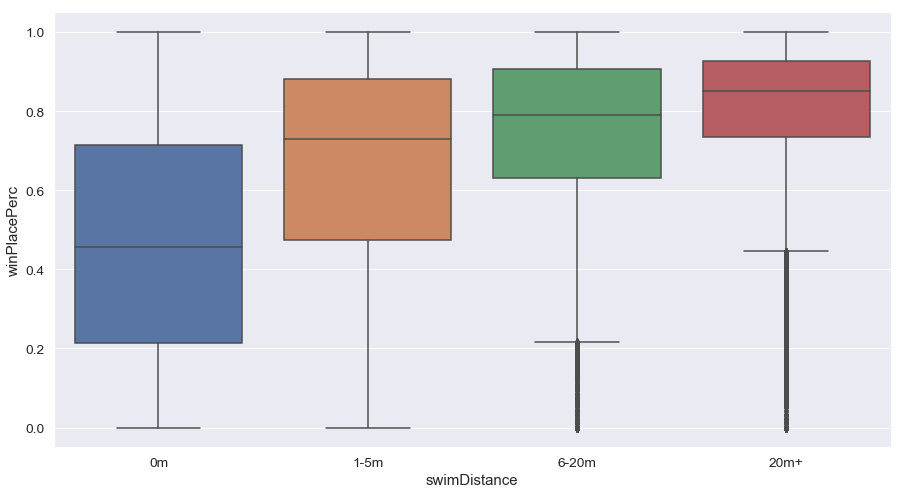

In [23]:

data['swimDistance'] = pd.cut(data['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=data)
plt.show()

In [24]:
print("The average person acquiared {:.1f}  weapons, 99% of people use {} or less, while the 武器大师 acquired {}.".format(data['weaponsAcquired'].mean(), data['weaponsAcquired'].quantile(0.99), data['weaponsAcquired'].max()))

The average person acquiared 3.6  weapons, 99% of people use 11.0 or less, while the 武器大师 acquired 153.


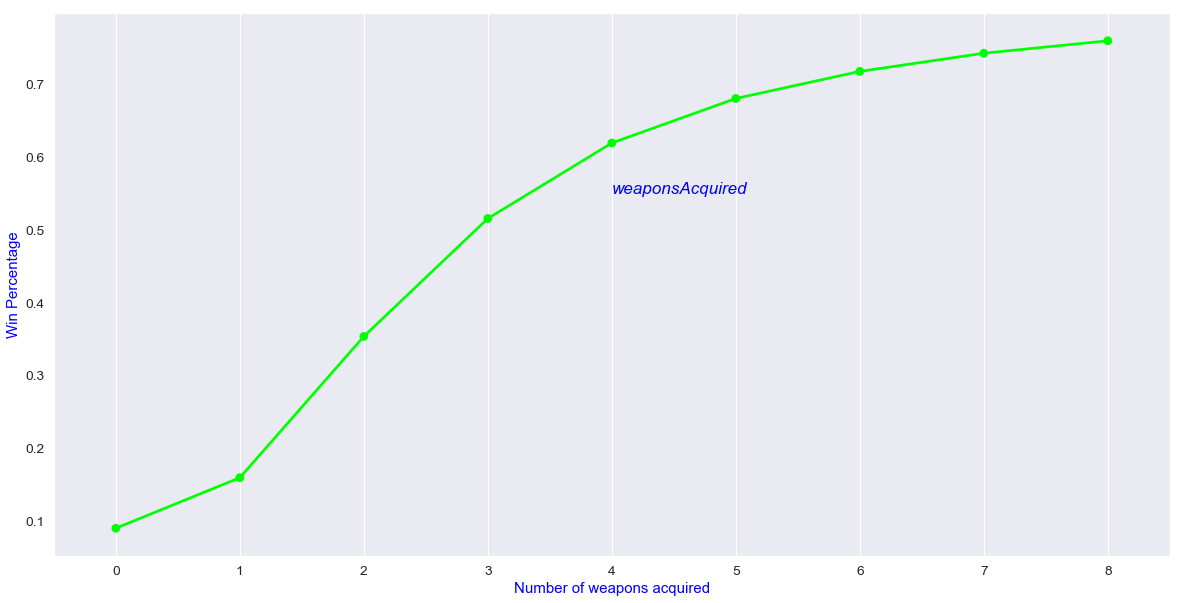

In [25]:
data = data[data['weaponsAcquired'] < data['weaponsAcquired'].quantile(0.99)]
data = data[data['weaponsAcquired'] < data['weaponsAcquired'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='weaponsAcquired',y='winPlacePerc',data=data,color='lime',alpha=0.8)
plt.text(4,0.55,'weaponsAcquired',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of weapons acquired',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.grid()
plt.show()

In [2]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(data['heals'].mean(), data['heals'].quantile(0.99), data['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(data['boosts'].mean(), data['boosts'].quantile(0.99), data['boosts'].max()))

NameError: name 'data' is not defined

In [3]:
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

NameError: name 'data' is not defined

In [4]:
data['heal+boost'] = data['heals'] + data['boosts']

NameError: name 'data' is not defined

In [5]:
numeric_cols = [i for i in data.columns if (data[i].dtypes!= object)&(data[i].dtype.name!= 'category')]

NameError: name 'data' is not defined

In [6]:
data.columns

NameError: name 'data' is not defined

In [7]:
data = data[numeric_cols]

NameError: name 'data' is not defined

In [8]:
data = data[~data['winPlacePerc'].isnull()]

NameError: name 'data' is not defined

In [9]:
data_5_col = data[['winPlacePerc','walkDistance','heal+boost','weaponsAcquired','damageDealt']]

data_5_col = data_5_col[data_5_col['walkDistance'] < data_5_col['walkDistance'].quantile(0.95)]
data_5_col = data_5_col[data_5_col['heal+boost'] < data_5_col['heal+boost'].quantile(0.95)]
data_5_col = data_5_col[data_5_col['weaponsAcquired'] < data_5_col['weaponsAcquired'].quantile(0.95)]
data_5_col = data_5_col[data_5_col['damageDealt'] < data_5_col['damageDealt'].quantile(0.95)]

NameError: name 'data' is not defined

In [10]:
data_5_col = data_5_col[~data_5_col['winPlacePerc'].isnull()]
data_5_col = data_5_col.reset_index(drop=True)
min_max_scaler = preprocessing.MinMaxScaler()
data_5_col_scaled = pd.DataFrame(min_max_scaler.fit_transform(data_5_col),columns=data_5_col.columns, index=data_5_col.index)

NameError: name 'data_5_col' is not defined

In [11]:
data_5_col_scaled.to_csv('data_5_col_scaled.csv',index=False)

NameError: name 'data_5_col_scaled' is not defined

In [12]:
data_5_col_scaled = pd.read_csv('data_5_col_scaled.csv')

rows = np.random.choice(data_5_col_scaled.index.values, 30000)
X = data_5_col_scaled.loc[rows]
y = data_5_col_scaled['winPlacePerc'].loc[rows]
# X = data_5_col_scaled
# y = data_5_col_scaled['winPlacePerc']


range_n_clusters = range(3,7)

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(init='k-means++',n_clusters=n_clusters, random_state=10,max_iter =3)
#     clusterer = MiniBatchKMeans(init='k-means++',n_clusters=n_clusters, random_state=10,batch_size=500,max_iter =2)
#     clusterer = SpectralClustering(n_clusters=n_clusters)
#     cluster_labels = clusterer.fit_predict(X)
    clusterer_ = clusterer.fit(X[[ 'walkDistance','heal+boost','weaponsAcquired','damageDealt']])
    cluster_labels = clusterer_.predict(X[[ 'walkDistance','heal+boost','weaponsAcquired','damageDealt']])


    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm_.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

FileNotFoundError: File b'data_5_col_scaled.csv' does not exist

In [ ]:
X

In [ ]:
clusterer = KMeans(init='k-means++',n_clusters=4, random_state=10,max_iter =3)
clusterer_ = clusterer.fit(X)
cluster_labels = clusterer_.predict(X)


X['Label'] = cluster_labels
X = X.reset_index(drop=True)



categories=['winPlacePerc',
 'walkDistance',
 'heal+boost',
 'weaponsAcquired',
 'damageDealt']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.yticks([0.3,0.6,1], ["0.3","0.6","1"], color="grey", size=17)
plt.ylim(0,1)

colors = ['b','r','g','y']

for i in range(4):
    X_ = X[X['Label']==i][['winPlacePerc','walkDistance','heal+boost','weaponsAcquired','damageDealt']]
    values= X_.mean().values.flatten().tolist()
    values += values[:1]
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=i)
    ax.fill(angles, values, colors[i], alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

In [13]:
categories=list(data_5_col_scaled[1:])
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.yticks([0.3,0.6,1], ["0.3","0.6","1"], color="grey", size=17)
plt.ylim(0,1)
############# 高手

values = data_5_col_scaled[data_5_col_scaled['winPlacePerc']>=0.8].mean().values.flatten().tolist()
values += values[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.set_rlabel_position(0)
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Expert")
ax.fill(angles, values, 'b', alpha=0.1)



############# 优秀

values= data_5_col_scaled[(data_5_col_scaled['winPlacePerc']>0.5)&(data_5_col_scaled['winPlacePerc']<0.8)]\
            .mean().values.flatten().tolist()
values += values[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.set_rlabel_position(0)
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Good")
ax.fill(angles, values, 'r', alpha=0.1)


############# 菜鸡儿

values= data_5_col_scaled[data_5_col_scaled['winPlacePerc']<=0.5].mean().values.flatten().tolist()
values += values[:1]


ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.set_rlabel_position(0)
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Noob")
ax.fill(angles, values, 'g', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


NameError: name 'data_5_col_scaled' is not defined

In [14]:
plot_one(data_5_col_scaled,'winPlacePerc')

NameError: name 'plot_one' is not defined

In [15]:

dtrain = xgb.DMatrix(data[[i for i in data.columns if i != 'winPlacePerc']], label=data['winPlacePerc'], missing =np.NAN)
param = {
        'objective':'reg:linear',
        'n_estimators':200,
        'learning_rate':0.1,
        'gamma':0,
        'max_depth':5,
        'min_child_weight':1,
        'colsample_bytree':0.5,
        'subsample': 0.8, 
        'verbose':0,
        'reg_alpha':0}

res = xgb.cv(param,dtrain, num_boost_round=100,nfold=5,metrics={'rmse'},seed = 0, verbose_eval=50,as_pandas = True)
res

NameError: name 'xgb' is not defined